In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reactionmodel.model import Species, Reaction, Model

Evaluating expression: beta / n => 0.03
Evaluating expression: gamma => 0.5


Text(0, 0.5, 'individuals')

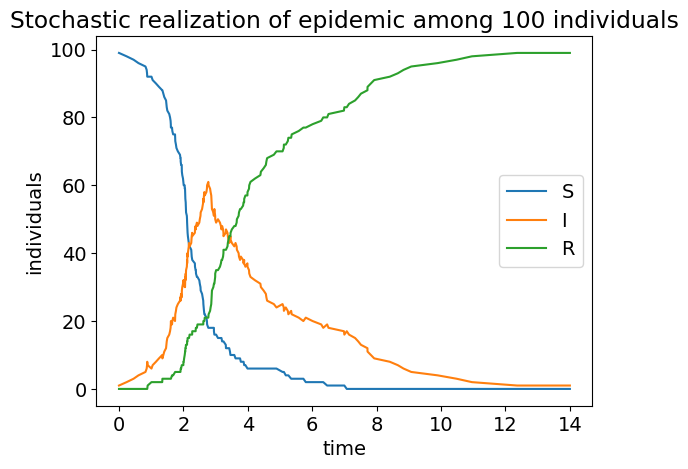

In [2]:
S = Species('S')
I = Species('I')
R = Species('R')

reactions = [
    Reaction([S, I], [(I, 2)], k='beta / n'),
    Reaction(I, R, k='gamma')
]

m = Model([S, I, R], reactions)

from hybrid.gillespie import GillespieSimulator

p = parameters={'beta': 3.0, 'gamma': 0.5, 'n': 100}

s = GillespieSimulator(
    m.get_k(jit=True, parameters=p),
    m.stoichiometry(),
    m.kinetic_order(),
)

plt.rc('font', size=14) 
result = s.simulate([0.0, 14.0], m.make_initial_condition({'S':99, 'I':1}, parameters=p), np.random.default_rng())
ax = result.plot(m.legend())
ax.set_title('Stochastic realization of epidemic among 100 individuals')
ax.set_xlabel('time')
ax.set_ylabel('individuals')

Evaluating expression: beta / n => 0.003
Evaluating expression: gamma => 0.5
Evaluating expression: beta / n => 0.003
Evaluating expression: gamma => 0.5


/Users/thayer/develop/hybrid/hybrid/tau.py:189: RuntimeWarning: divide by zero encountered in divide
  tau1 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1) / np.abs(mu_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:190: RuntimeWarning: divide by zero encountered in divide
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))
/Users/thayer/develop/hybrid/hybrid/tau.py:190: RuntimeWarning: overflow encountered in square
  tau2 = np.min(np.maximum(np.nan_to_num(y * epsilon / g, 0), 1)**2 / np.abs(sigma_2_hat_i))


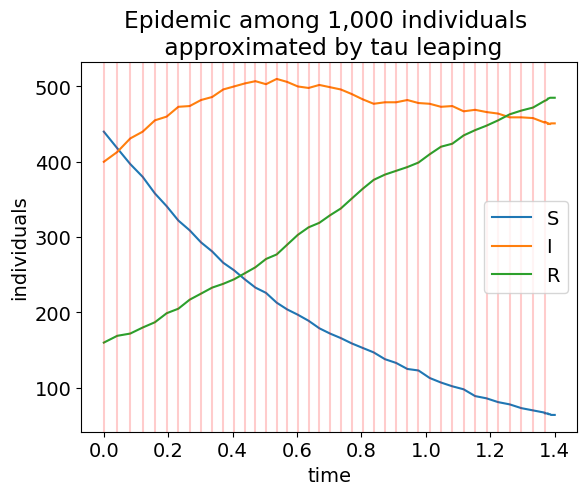

In [3]:

from hybrid.tau import TauLeapSimulator, TauStepStatus

p = parameters={'beta': 3.0, 'gamma': 0.5, 'n': 1000}

t_s = TauLeapSimulator(
    m.get_k(jit=True, parameters=p),
    m.stoichiometry(),
    m.kinetic_order(),
    epsilon=0.1
)

s = GillespieSimulator(
    m.get_k(jit=True, parameters=p),
    m.stoichiometry(),
    m.kinetic_order(),
)

plt.rc('font', size=14) 
result = t_s.simulate([0.0, 1.4], m.make_initial_condition({'S':440, 'I':400, 'R':160}, parameters=p), np.random.default_rng())
ax = result.plot(m.legend() + ['leap'])
ax.set_title('Epidemic among 1,000 individuals \n approximated by tau leaping')
ax.set_xlabel('time')
ax.set_ylabel('individuals')

for t in result.t_history[result.status_history == TauStepStatus.leap]:
    ax.axvline(t, color='r', alpha=0.2)

In [4]:
result.status_counter

Counter({<TauStepStatus.leap: 0>: 39,
         <TauStepStatus.gillespie_stochastic: 3>: 7,
         <TauStepStatus.rejected_for_gillespie: -2>: 1,
         <TauStepStatus.gillespie_t_end: 2>: 1})

## The basic model of virus dynamics

The basic model for virus dynamics is:

$$ \dot{x} = \lambda - d x - \beta x v $$
$$ \dot{y} = \beta x v - a y $$
$$ \dot{v} = ky - uv $$

where $\lambda$ is the constant rate of replishment of susceptible cells, $d$ is the death rate of susceptible cells, $a$ is the death rate of infected cells, $u$ is the clearance rate of virus, $k/a$ is the burst size (# of viruses produced by infected cells over their lifespan), and $\beta$ is the per contact rate at which susceptible cells become infected by virus.

## Steady state assumption for $v$

If $u >> a$, then to a good approximation, $v$ is in a steady state ($\dot{v} = 0$). In that case, the viral load is proportional to the concentration of infected cells $v = k y / u$. Let $b = \beta k / u$, then we have the reduced system:

$$ \dot{x} = \lambda - dx - b x y$$
$$ \dot{y} = b x y - ay $$

(This is all directly as written in Nowak Virus Dynamics 10.4-10.5.) Below we will refer to this as the $v$ steady-state model.

In this model, at all times the amount of virus is equal to

$$ v = a \cdot \text{burst size} \cdot y / u $$

where $u$ is the rate of viral clearance and the burst size is the average # of viruses produced by infected cells over their lifespan.

In [5]:
x  = Species('x')
y = Species('y')

reactions = []
reactions.append(Reaction([x], [], k='d'))
reactions.append(Reaction([], [x], k='l'))
reactions.append(Reaction([y], [], k='a'))
reactions.append(Reaction([x, y], [(y, 2)], k='b'))

m_v_steady = Model([x, y], reactions)

For a HIV where $R_0$ is given, the parameters have these approximate values:

$$ a = 1.0 $$
$$ d = 0.05$$
$$ \lambda = 1.36 \cdot 10^{10} = 1.36e9$$
$$ b = a R_0 / x^* = a R_0 d / \lambda = 3.68 R_0 \cdot 10^{-11}$$

Let $\rho = a \cdot \text{burst size} / u$ then 

$$ \rho = 1.0 * 10000 / 25 = 400 $$

In [6]:
R0 = 1.75
p_v_steady = {
    'a': 1.0,
    'd': 0.05,
    'l': 1.36e9,
    'b': 3.68e-11*R0
}

burst_size = 10000
clearance_rate = 25

At infected equilibrium, the population of infected cells is 

Evaluating expression: l/d => 27200000000.0
Evaluating expression: d => 0.05
Evaluating expression: l => 1360000000.0
Evaluating expression: a => 1.0
Evaluating expression: b => 6.439999999999999e-11


[]

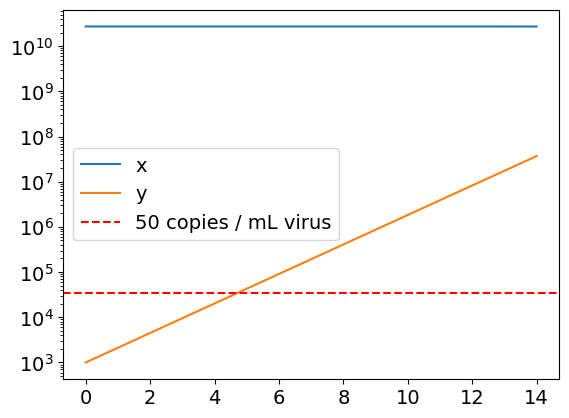

In [7]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

t_span = [0.0, 14.0]
t_eval = np.linspace(t_span[0], t_span[-1], 100)
y0 = m_v_steady.make_initial_condition({'y': 1000, 'x': 'l/d'}, parameters=p_v_steady)

result = solve_ivp(m_v_steady.get_dydt(parameters=p_v_steady), t_span, y0, t_eval=t_eval)


ax = plt.subplot()
ax.plot(t_eval, result.y.T)
ax.axhline(13.5e6/(burst_size)*clearance_rate, c='r', linestyle='--')
ax.legend(m_v_steady.legend()+['50 copies / mL virus'])
ax.semilogy()

In [8]:
13.5e6/400

33750.0

Suppose that our initial # of infected cells was Poisson distributed with mean $n$. We want to understand the answer to the question: "after $t$ days what is the probability that the copies / mL of virus is greater than the 50 copies / mL detection limit?"

Assuming deterministic exponential growth, the state of the system at time $t$ is (note, that we are making the safe assumption that CD4+ T-cell populations are essentially constant during this early period of growth):

$$ y(t) = y_0 e^{a (R_0 - 1) t} $$

for a fixed $t$ and $R_0$

$$ v(t) \ge \text{threshold} \Rightarrow y(t) \ge \text{threshold} / \rho = 33,750$$
$$ \Rightarrow y_0 \ge 33,750 / e^{a (R_0 - 1) t} $$

Suppose that the mean starting population of $y$, $n$, is $100$ and $R_0 = 2.0$ 

$$ Y_0 = \text{Poiss} (n) $$
$$ \text{Pr} \{v(t) \ge \text{threshold}\} = 1 - F_{Y_0} (33,750 / e^{a (R_0 - 1) t}) $$

Text(0.5, 1.0, '')

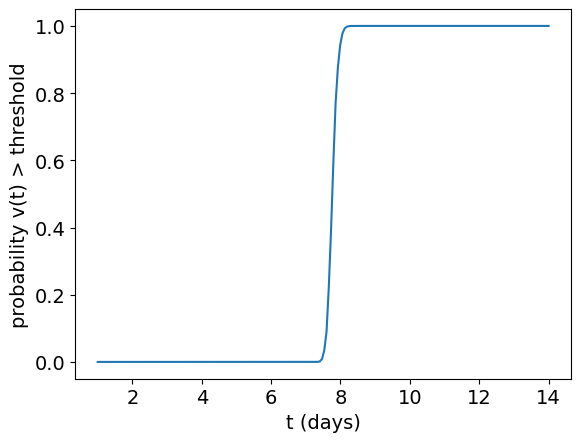

In [9]:
import scipy.stats

n = 100

t = np.linspace(1.0, 14.0, 200)
poiss = scipy.stats.poisson(n)

pr = [1 - poiss.cdf(33750/np.exp(p_v_steady['a'] * (R0-1)*t)) for t in t]

ax = plt.subplot()
ax.plot(t, pr)
ax.set_ylabel('probability v(t) > threshold')
ax.set_xlabel('t (days)')
ax.set_title('')

What if, instead, the distribution is highly overdispersed (e.g. a negative binomial distribution with $p << 1$):

Text(0.5, 1.0, '')

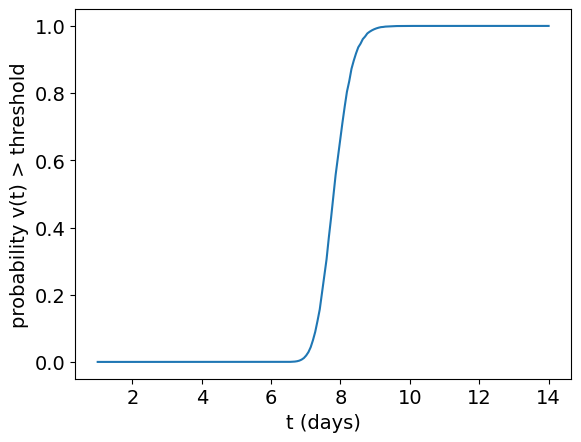

In [10]:
p = 0.1
r = n*p/(1-p)

nb = scipy.stats.nbinom(r, p)

pr = [1 - nb.cdf(33750/np.exp(p_v_steady['a'] * (R0-1)*t)) for t in t]
ax = plt.subplot()
ax.plot(t, pr)
ax.set_ylabel('probability v(t) > threshold')
ax.set_xlabel('t (days)')
ax.set_title('')

In [11]:
nb.rvs()

93

## Iterated latency AUC

In [12]:
from reactionmodel.model import Species, Reaction, Model

x = Species('x')
y = Species('y')
z = Species('z')

reactions = []
reactions.append(Reaction([x], [], k='d'))
reactions.append(Reaction([], [x], k='l'))
reactions.append(Reaction([y], [], k='a'))
reactions.append(Reaction([x, y], [(y, 2)], k='b'))
reactions.append(Reaction([x, y], [y, z],  k='g*b'))
reactions.append(Reaction([z], [y], k='reactivation'))
reactions.append(Reaction([z], [], k='dz'))


p_repeated_latency = p_v_steady.copy()
p_repeated_latency['reactivation'] = 3.7e-4
p_repeated_latency['g'] = 1.1e-6
p_repeated_latency['dz'] = 1.5e-4

m_repeated_latency = Model([x, y, z], reactions)

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

n = 100
p = 0.1
r = n*p/(1-p)
nb = scipy.stats.nbinom(r, p)
results = []
t_span = [0.0, 14.0]
t_eval = np.linspace(t_span[0], t_span[-1], 100)
for i in range(100):
    #z0 = scipy.stats.poisson(100).rvs()
    z0 = nb.rvs()
    y0 = m_repeated_latency.make_initial_condition({'z':z0, 'x': 'l/d'}, parameters=p_repeated_latency)
    r = solve_ivp(m_repeated_latency.get_dydt(parameters=p_repeated_latency), t_span, y0, t_eval=t_eval)
    y = r.y.T
    d = pd.DataFrame(y, columns=['_' + c + f'{i}' for c in m_repeated_latency.legend()], index=t_eval)
    results.append(d)

df = pd.concat(results, axis=1)

In [142]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

n = 100
p = 0.1
r = n*p/(1-p)
nb = scipy.stats.nbinom(r, p)
results = []
t_span = [0.0, 42.0]
t_eval = np.linspace(t_span[0], t_span[-1], 100)
for i in range(20):
    z0 = scipy.stats.poisson(100).rvs()
    #z0 = nb.rvs()
    y0 = m_repeated_latency.make_initial_condition({'z':z0, 'x': 'l/d'}, parameters=p_repeated_latency)
    r = solve_ivp(m_repeated_latency.get_dydt(parameters=p_repeated_latency), t_span, y0, t_eval=t_eval)
    y = r.y.T
    d = pd.DataFrame(y, columns=['_' + c + f'{i}' for c in m_repeated_latency.legend()], index=t_eval)
    results.append(d)

df = pd.concat(results, axis=1)

Evaluating expression: l/d => 27200000000.0
Evaluating expression: d => 0.05
Evaluating expression: l => 1360000000.0
Evaluating expression: a => 1.0
Evaluating expression: b => 6.439999999999999e-11
Evaluating expression: g*b => 7.084e-17
Evaluating expression: reactivation => 0.00037
Evaluating expression: dz => 0.00015
Evaluating expression: l/d => 27200000000.0
Evaluating expression: d => 0.05
Evaluating expression: l => 1360000000.0
Evaluating expression: a => 1.0
Evaluating expression: b => 6.439999999999999e-11
Evaluating expression: g*b => 7.084e-17
Evaluating expression: reactivation => 0.00037
Evaluating expression: dz => 0.00015
Evaluating expression: l/d => 27200000000.0
Evaluating expression: d => 0.05
Evaluating expression: l => 1360000000.0
Evaluating expression: a => 1.0
Evaluating expression: b => 6.439999999999999e-11
Evaluating expression: g*b => 7.084e-17
Evaluating expression: reactivation => 0.00037
Evaluating expression: dz => 0.00015
Evaluating expression: l/d =

[]

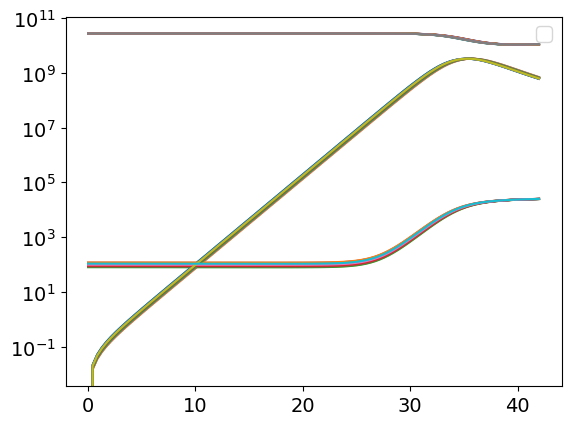

In [143]:
ax = df.plot()
ax.semilogy()

In [ ]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner
import matplotlib.pyplot as plt

h_s = HybridSimulator(
    m_repeated_latency.get_k(parameters=p_repeated_latency, jit=True),
    m_repeated_latency.stoichiometry(),
    m_repeated_latency.kinetic_order(),
    FixedThresholdPartitioner(100.0),
)

results = []
t_span = [0.0, 14.0]
t_eval = np.linspace(t_span[0], t_span[-1], 100)
for i in range(100):
    z0 = scipy.stats.poisson(100).rvs()
    y0 = m_repeated_latency.make_initial_condition({'z':z0, 'x': 'l/d'}, parameters=p_repeated_latency)
    r = h_s.simulate(t_span, y0, np.random.default_rng(), t_eval=t_eval)
    y = r.y_history.T
    d = pd.DataFrame(y, columns=['_' + c + f'{i}' for c in m_repeated_latency.legend()], index=r.t_history)
    d = d.loc[t_eval]
    results.append(d)

df = pd.concat(results, axis=1)

[]

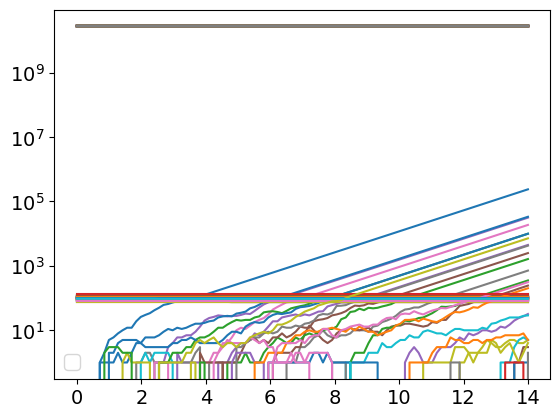

In [16]:
ax = df.plot()
ax.semilogy()

### Thresholds and establishment probabilities

In the early period of establishment of a strain with given $R_0$ and a death rate of $a$, the following system characterizes the behavior:

$$ Y \to 2 Y \qquad a R_0 $$
$$ Y \to \emptyset \qquad a $$

and with a starting population of $n$ the probability of establishment is

$$ P_\text{establishment}  = 1 - \left( \frac{1}{R_0} \right)^n $$

Suppose that we use a hybrid simulator that treats any reaction as totally deterministic provided that its rate is greater than $p_T$ events per day where $p_T$ is called the partition threshold. As a function of $a$ and $R_0$, what is the extinction probability given a starting population where the system will be simulated deterministically? If this number is close to 0, the simulator will accurately capture the extinction behavior. If it is $> 0$, then the simulator will neglect that probability of extinction.

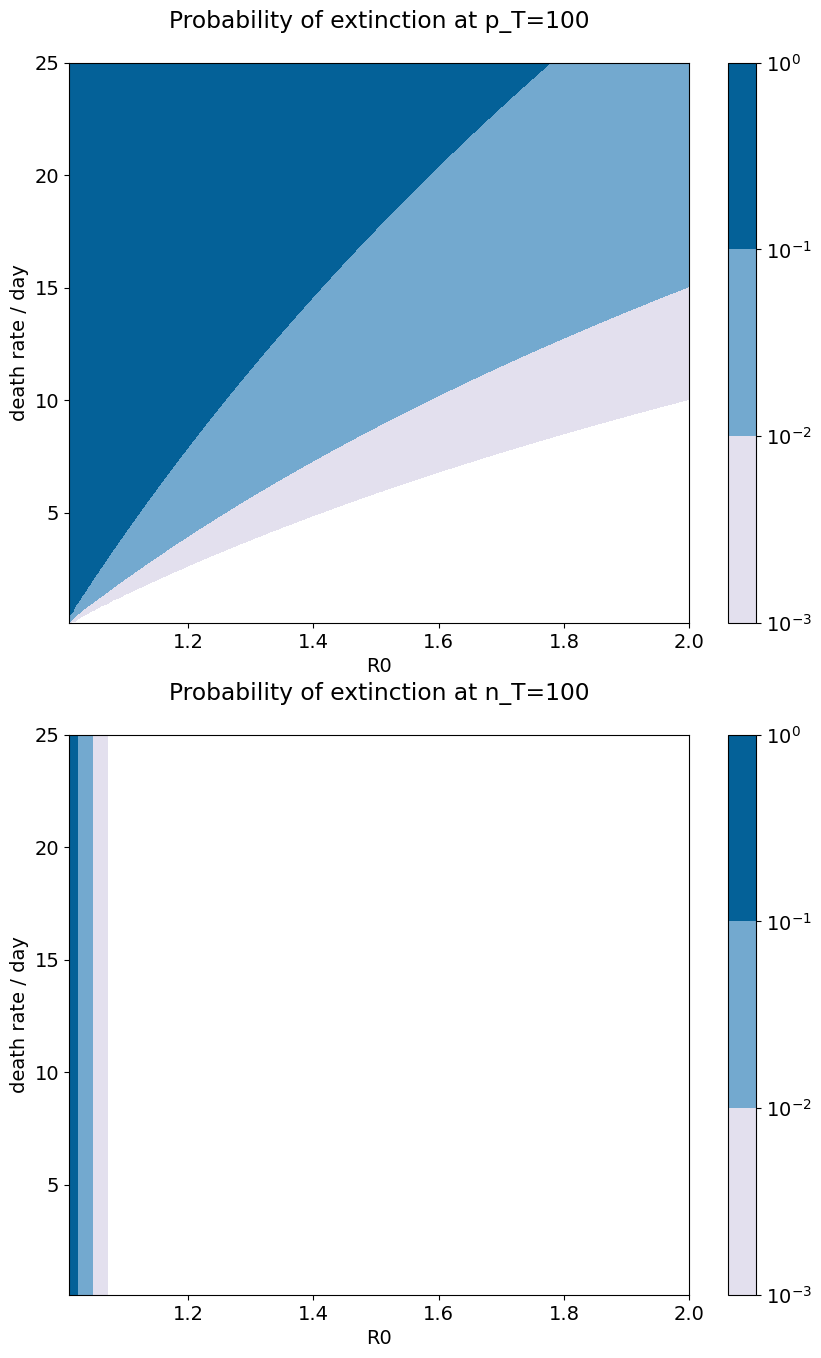

In [138]:
from matplotlib.colors import LogNorm

p_T = 100

a_axis = np.linspace(0.1, 25.0, 100)
R0_axis = np.linspace(1.01, 2.0, 100)

A, R0 = np.meshgrid(a_axis, R0_axis)

n_deterministic = p_T/A
n_T = 100
#n_deterministic = np.maximum(n_deterministic, n_deterministic_min)
p_extinction = (1/R0)**n_deterministic

fig, ax = plt.subplots(2,1, figsize=(10,16))

h = ax[0].contourf(R0, A, p_extinction, levels=[1e-3, 1e-2, 1e-1, 1e0],cmap=plt.cm.PuBu,norm = LogNorm())
ax[0].set_title(f'Probability of extinction at p_T={p_T}\n')
ax[0].set_ylabel('death rate / day')
ax[0].set_xlabel('R0')

h = ax[1].contourf(R0, A, (1/R0)**n_T, levels=[1e-3, 1e-2, 1e-1, 1e0],cmap=plt.cm.PuBu,norm = LogNorm())
ax[1].set_title(f'Probability of extinction at n_T={n_T}\n')
ax[1].set_ylabel('death rate / day')
ax[1].set_xlabel('R0')

fig.colorbar(h, ax=ax[0])
fig.colorbar(h, ax=ax[1])


#plt.axvline(1.0, color='r', linestyle='--')
#plt.axvline(10.0, color='r', linestyle='--')


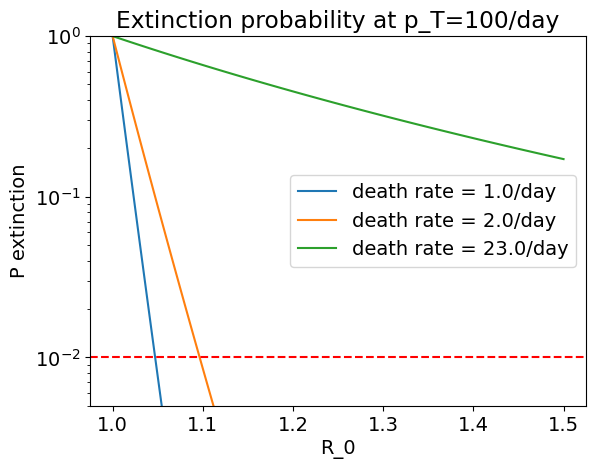

In [61]:
r0 = np.linspace(1.0, 1.5, 100)
a = 1.0
p_T = 100
n_deterministic = p_T/a

ax = plt.subplot()
ax.plot(r0, (1/r0)**n_deterministic)
ax.semilogy()
plt.title(f'Extinction probability at p_T={p_T}/day')
plt.xlabel('R_0')
plt.ylabel('P extinction')
plt.ylim([5e-3, 1])

a = 2.0
n_deterministic = p_T/a
ax.plot(r0, (1/r0)**n_deterministic)

a = 23.0
n_deterministic = p_T/a
ax.plot(r0, (1/r0)**n_deterministic)

#n_deterministic = 100
#p_extinction = (1/r0)**n_deterministic
#ax.plot(r0, p_extinction)
plt.axhline(0.01, color='r', linestyle='--')

ax.legend(['death rate = 1.0/day', 'death rate = 2.0/day', 'death rate = 23.0/day'])

## Drug resistant mutant

Suppose that there are two strains of the virus $y_s$ and $y_r$, the former which is susceptible to an anti-viral drug and the latter which is resistant. Then our system, with the steady-state approximation for $v$, becomes:

$$ \dot{x} = \lambda - d x - (s b_s y_s + b_r y_r) x $$
$$ \dot{y_s} = (s b_s x - a) y_s $$
$$ \dot{y_r} = (b_r x - a) y_r $$

where $s \in [0, 1]$ is a parameter that characterizes the drug's inhibition of infection of susceptibles by the sensitive virus.

So far, this is all exactly as written in Novak 2000. Let us introduce the additional term of a mutation rate $\mu << 1$, where mutation occurs at the point of infection:

$$ \dot{x} = \lambda - d x - (s b_s y_s + b_r y_r) x $$
$$ \dot{y_s} = (s b_s (1 - \mu) x - a) y_s \approx (s b_s x - a) y_s $$
$$ \dot{y_r} = (b_r x + s b_s \mu - a) y_r $$

We will refer to this as the $v$ steady-state model with drug and mutation.

In [23]:
ys = Species('y_s')
yr = Species('y_r')

reactions = []
reactions.append(Reaction([x], [], k='d'))
reactions.append(Reaction([], [x], k='l'))
reactions.append(Reaction([ys], [], k='a'))
reactions.append(Reaction([yr], [], k='a'))
reactions.append(Reaction([x, ys], [(ys, 2)], k='s*b_s'))
reactions.append(Reaction([x, yr], [(yr, 2)], k='b_r'))
reactions.append(Reaction([x, ys], [ys, yr], k='s*b_s*mu'))

m_v_steady_with_drug = Model([x, ys, yr], reactions)


## Latency

A topic of huge importance in the context of HIV is the latent reservoir: quiescent CD4+ T-cells that harbor HIV virus in their genome. These cells can (1) **reactivate** from the quiescent state and produce new virus particles and (2) be **seeded** by actively infected cells that enter the quiescent state and (3) **die**, at a much slower rate ($<< \lambda$) than an active CD4+ T-cell. Because of these long-lived latently infected cells, HIV cannot be cured through ART. 

Later, we will consider a model of virus dynamics that incorporates latency in all its parts, but latency has a notable effect that is both (a) important to capture in our simulation approach (b) helpful in designing tests of our simulation approach: due to reactivation from latency, infected cell populations will not decline to 0 copies / mL even in the presence of a drug that is 100% effective in inhibiting new infections, as some number of actively infected cells will be sustained in the bloodstream as they "wake up" from the quiescent state. Due to this phenomenon, viral loads (proxied in the $v$-steady state model by numbers of infected cells) will hover at low levels, where stochastic fluctuations matter the most. On the timescales of interest, the size of the latent reservoir will not meaningfully decline (half life of ~1,300 days). Therefore we will model this effect with a small zeroeth birth rate for wildtype infected cells:

$$ \dot{y_s} = (s b_s x - a) y_s + \eta$$

Whenever this $\eta$ term is included, we will say it is a model with "constant reactivation." We ignore reactivation of latently infected resistant cells (for now).

In [24]:
reactions.append(Reaction([], [ys], k='eta'))

m_v_steady_with_drug_and_reactivation = Model([x, ys, yr], reactions)

## Experiments

### Probability / unit time of mutant emergence

Our simplest experiment is also one of our most important. Suppose that the viral load of wildtype viruses is (a) suppressed by the administration of a drug that reduces $R_0 < 1$ but (b) sustained at a low level by constant reactivation from the latent reservoir. Suppose also that there are zero initial copies of the drug resistant mutant.

What is the probability per unit time that a drug resistant mutant emerges and escapes stochastic extinction?

The answer obviously depends on the exact parameters. To clarify how the virus dynamics parameters inform the answer, we adjust our parametrization by introducing the following parameters: equilibrium viral load $y^*$ with drug present, the fraction of that equilibrium viral load that is sustained by replication (as opposed to reactivation) $f_\text{rep}$, the basic reproductive number of the mutant virus $R_\mu$. These replace some of our existing parameters in the following fashion:


$$ s \cdot b_s = \frac{a f_\text{rep} d}{\lambda} $$
$$ b_r = \frac{a R_\mu d}{\lambda} $$
$$ \eta = y^* a (1 - f_\text{rep}) $$

Leaving us with the following revision of the dynamical system (note that we have shed one parameter because $s$ and $b_s$ always appeared as a product):

$$ \dot{x} = \lambda - d x - \left(\frac{a f_\text{rep} d}{\lambda} y_s + \frac{a R_\mu d}{\lambda} y_r\right) x $$
$$ \dot{y_s} = \left(\frac{a f_\text{rep} d}{\lambda} x - a\right) y_s + y^* a (1 - f_\text{rep})$$
$$ \dot{y_r} = \left(\frac{a R_\mu d}{\lambda} x + \frac{a f_\text{rep} d \mu}{\lambda} - a\right) y_r $$

Mutants are generated at a rate of $a f_\text{rep} \mu y^*$. A single mutant introduced at equilibrium infects target cells at a rate $a R_\mu$

If this question turns out to be hard to ask our simulator, let us instead ask: What is the distribution of times until a resistant mutant emerges and escapes stochastic extinction?

In [28]:
from dataclasses import dataclass

@dataclass
class MutantEmergenceParameters():
    d: float
    a: float
    l: float
    y0: float
    f_rep: float
    mu: float
    R_mu: float

    def __post_init__(self):
        print(f"Mutant generation rate: {self.mutant_generation_rate():0.3f}")
        print(f"Mutant infection rate at eq: {self.mutant_infection_rate_at_eq()}")
        print(f"Maximum implied s: {self.to_standard()['s']:0.3f}")

    def mutant_generation_rate(self):
        return self.a*self.f_rep*self.mu*self.y0

    def mutant_infection_rate_at_eq(self):
        return self.a*self.R_mu

    def initial(self):
        initial = {
            'x' : self.l / self.d,
            'y_s': self.y0,
            'y_r': 0,
        }
        return initial

    def to_standard(self):
        initial = self.initial()
        standard = {
            'd' : self.d,
            'a' : self.a,
            'l' : self.l,
            'mu': self.mu
        }
        standard['b_r'] = self.a * self.R_mu / initial['x']
        # we manage to reduce our # of parameters by 1, because s * b_s always appear in combination
        standard['b_s'] = standard['b_r']
        s_b_s_product = self.a * self.f_rep / initial['x']
        standard['s'] = s_b_s_product / standard['b_r']
        standard['eta'] = self.y0 * self.a * (1 - self.f_rep)

        return standard

    def to_gillespie_compatible_parameters(self):
        pass

m = m_v_steady_with_drug_and_reactivation
p = MutantEmergenceParameters(**{
    'd': 0.05,
    'a': 1.0,
    'l': 1e10,
    'mu': 1e-6,
    'R_mu': 1.5,
    'y0': 1e5,
    'f_rep': 0.4
})

Mutant generation rate: 0.040
Mutant infection rate at eq: 1.5
Maximum implied s: 0.267


In [29]:
params = p.to_standard()
initial = m.make_initial_condition(p.initial(), parameters=params)

In [30]:
from scipy.integrate import solve_ivp
t_eval = np.linspace(0, 120, 121)

result = solve_ivp(m.get_dydt(jit=False, parameters=params), [0.0, 120.0], initial, t_eval=t_eval)

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 2e-12
Evaluating expression: b_r => 7.5e-12
Evaluating expression: s*b_s*mu => 1.9999999999999998e-18
Evaluating expression: eta => 60000.0


In [31]:
df = pd.DataFrame(index=result.t, data={name:v for name, v in zip(m.legend(), result.y)})

In [40]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

s = HybridSimulator(
    m.get_k(parameters=params, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    FixedThresholdPartitioner(100.0),
)

s2 = HybridSimulator(
    m.get_k(parameters=params, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    FixedThresholdPartitioner(5.0),
)

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 2e-12
Evaluating expression: b_r => 7.5e-12
Evaluating expression: s*b_s*mu => 1.9999999999999998e-18
Evaluating expression: eta => 60000.0
Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 2e-12
Evaluating expression: b_r => 7.5e-12
Evaluating expression: s*b_s*mu => 1.9999999999999998e-18
Evaluating expression: eta => 60000.0


In [43]:
hybrid_df = pd.DataFrame()
for i in range(1000):
    result = s.simulate([0.0, 120.0], initial, np.random.default_rng(), t_eval=t_eval)
    y_r = result.y_history[m.legend().index('y_r')]
    r = pd.Series(data=y_r, index=result.t_history)
    r = r[t_eval]
    r.name = f'_r{i}'
    hybrid_df = pd.concat([hybrid_df, r], axis=1)

In [41]:
hybrid_df2 = pd.DataFrame()
for i in range(1000):
    result = s2.simulate([0.0, 120.0], initial, np.random.default_rng(), t_eval=t_eval)
    y_r = result.y_history[m.legend().index('y_r')]
    r = pd.Series(data=y_r, index=result.t_history)
    r = r[t_eval]
    r.name = f'_r{i}'
    hybrid_df2 = pd.concat([hybrid_df2, r], axis=1)

Text(0, 0.5, '# specimens')

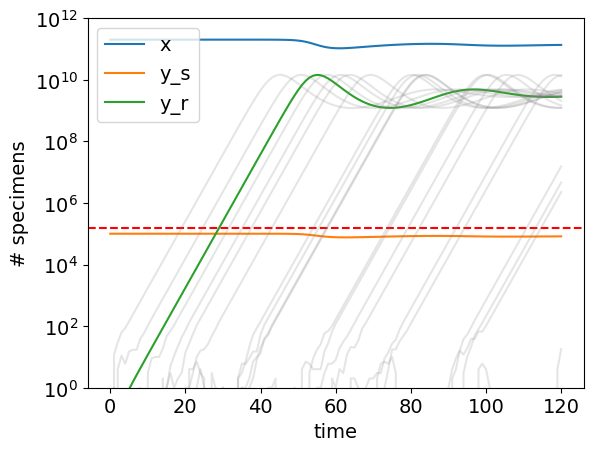

In [72]:
ax = df.plot(logy=True)
ax.axhline(3000*50, linestyle='--', color='r')
hybrid_df.T.iloc[:25].T.plot(ax=ax, colormap=lambda x: 'grey', alpha=0.2)
ax.set_ylim([1, 1e12])
ax.set_xlabel('time')
ax.set_ylabel('# specimens')

In [51]:
from hybrid.tau import TauLeapSimulator

s = TauLeapSimulator(
    m.get_k(parameters=params, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

s2 = TauLeapSimulator(
    m.get_k(parameters=params, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    epsilon=0.05
)

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 2e-12
Evaluating expression: b_r => 7.5e-12
Evaluating expression: s*b_s*mu => 1.9999999999999998e-18
Evaluating expression: eta => 60000.0
Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 2e-12
Evaluating expression: b_r => 7.5e-12
Evaluating expression: s*b_s*mu => 1.9999999999999998e-18
Evaluating expression: eta => 60000.0


In [ ]:
tau_df = pd.DataFrame()
for i in range(1000):
    result = s.simulate([0.0, 120.0], initial, np.random.default_rng(), t_eval=t_eval)
    y_r = result.y_history[m.legend().index('y_r')]
    r = pd.Series(data=y_r, index=result.t_history)
    r = r[t_eval]
    assert(len(r) == len(t_eval))
    r.name = f'_r{i}'
    tau_df = pd.concat([tau_df, r], axis=1)

In [ ]:
tau_df2 = pd.DataFrame()
for i in range(1000):
    result = s2.simulate([0.0, 120.0], initial, np.random.default_rng(), t_eval=t_eval)
    y_r = result.y_history[m.legend().index('y_r')]
    r = pd.Series(data=y_r, index=result.t_history)
    r = r[t_eval]
    assert(len(r) == len(t_eval))
    r.name = f'_r{i}'
    tau_df2 = pd.concat([tau_df2, r], axis=1)

In [ ]:
result.status_counter

Counter({<TauStepStatus.leap: 0>: 5177,
         <TauStepStatus.leap_critical_combined: 1>: 236})

In [ ]:
ax = df.plot(logy=True)
ax.axhline(3000*50, linestyle='--', color='r')
tau_df.plot(ax=ax, colormap=lambda x: 'grey', alpha=0.2)
ax.set_ylim([1, 1e12])

### Analytic result

By Giorno and Nobile (20):

$$ \rho (t | t_0 ) \equiv \frac{e^{(\lambda - \mu)(t - t_0)} - 1}{\lambda e^{(\lambda - \mu)(t - t_0)} - \mu} \qquad \lambda \ne \mu $$

$$ p_{0,n} ( t | t_0) = \left[ \frac{\lambda - \mu}{\lambda e^{(\lambda - \mu)(t - t_0)} - \mu} \right]^{\nu / \lambda} \frac{1}{n!} \left( \frac{\nu}{\lambda} \right)_n [\lambda \rho(t | t_0)]^n $$

where $(x)_n$ is the Pochammer symbol.

$$ p_{0,0} (t | t_0) = \left[ \frac{\lambda - \mu}{\lambda e^{(\lambda - \mu)(t - t_0)} - \mu} \right]^{\nu / \lambda}  \qquad t \ne 0 $$

where $t_0 = 0$.

In [36]:
# Giorno and Nobile (20):

def p00_giorno(t, birth_rate, death_rate, immigration_rate):
    l = birth_rate
    mu = death_rate
    v = immigration_rate

    inside_brackets = (l - mu)/(l * np.exp((l-mu)*(t)) - mu)
    p00 = inside_brackets**(v/l)
    return p00

def p00_karlin(t, mu, l, beta):
    sigma = l/mu * np.exp(-(mu - l) * t)
    #print(sigma[:5])
    #print(np.log(1 - l/mu) + np.log(1 - sigma)[:5])
    #print(((mu - l) * t)[:5])
    log_p00 = -beta * (np.log(1 - l/mu) + np.log(1 - sigma)) - (mu - l) * beta * t
    #print(log_p00[:5])
    return np.exp(log_p00)

Text(0, 0.5, '$Pr \\{ y_r = 0 \\}$')

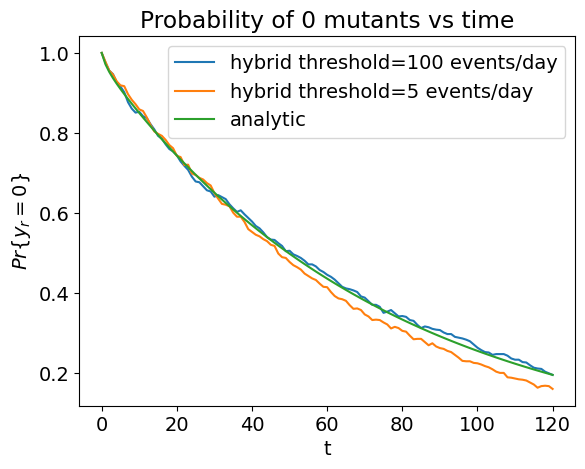

In [54]:
do_two = True
do_tau = False
do_hybrid = True
data = {}

if do_hybrid:
    hybrid_fraction = ((hybrid_df == 0).sum(axis=1) / len(hybrid_df.columns))
    data['hybrid threshold=100 events/day'] = hybrid_fraction
    if do_two:
        hybrid_fraction2 = ((hybrid_df2 == 0).sum(axis=1) / len(hybrid_df2.columns))
        data['hybrid threshold=5 events/day'] = hybrid_fraction2

if do_tau:
    tau_fraction = ((tau_df == 0).sum(axis=1) / len(tau_df.columns))
    data['tau epsilon=0.01'] = tau_fraction

    if do_two:
        tau_fraction2 = ((tau_df2 == 0).sum(axis=1) / len(tau_df2.columns))
        data['tau epsilon=0.05'] = tau_fraction2

probability_g = p00_giorno(t_eval, p.mutant_infection_rate_at_eq(), p.a, p.mutant_generation_rate())
data['analytic'] = probability_g


ax = pd.DataFrame(data=data).plot()
ax.set_title('Probability of 0 mutants vs time')
ax.set_xlabel('t')
ax.set_ylabel('$Pr \{ y_r = 0 \}$')

### A Gillespie compatible version

We also wish to compare the results of the approximate simulations to the results of a Gillespie simulation. We cannot execute a Gillespie simulation of the entire system --- if we modeled the target cell populations, the time taken for each run would be impossibly large.

Instead we consider a "one scale" Gillespie simulation, which assumes that the populations of target cells and wildtype cells are constant before the mutant escapes extinction and a "two scale" Gillespie simulation where we assume the population of only the target cells is constant (allowing for stochastic variation in the number of wildtype cells, and therefore in the rate of mutant production).

#### One scale Gillespie

$$ \emptyset \to y_r \qquad m $$
$$ y_r \to 2 y_r \qquad k_r$$
$$ y_r \to \emptyset \qquad a $$

In [ ]:
p

MutantEmergenceParameters(d=0.05, a=1.0, l=10000000000.0, y0=100000.0, f_rep=0.5, mu=1e-06, R_mu=1.5)

In [ ]:
y_r = Species('y_r')

reactions = []
reactions.append(Reaction([], [y_r], k='m'))
reactions.append(Reaction([y_r], [], k='a'))
reactions.append(Reaction([y_r], [(y_r, 2)], k='k_r'))

m_one_scale = Model([y_r], reactions)

matching_p = {
    'a': p.a,
    'm': p.mutant_generation_rate(),
    'k_r': p.mutant_infection_rate_at_eq()
}

In [ ]:
from hybrid.gillespie import GillespieSimulator

s = GillespieSimulator(
    m_one_scale.get_k(parameters=matching_p, jit=True),
    m_one_scale.stoichiometry(),
    m_one_scale.kinetic_order(),
)

Evaluating expression: m => 0.049999999999999996
Evaluating expression: a => 1.0
Evaluating expression: k_r => 1.5


In [ ]:
def halt(t, y):
    return y[m_one_scale.legend().index('y_r')] > 100

def expand_truncated(r, t_eval):
    end_point = r.iloc[-1]
    data = np.full_like(t_eval, end_point)
    r2 = pd.Series(data=data, index=t_eval)
    r2.name = r.name

    intersection = r2.index.intersection(r.index)
    r2[intersection] = r[intersection]

    return r2

gillespie_df = pd.DataFrame()
for i in range(1500):
    result = s.simulate([0.0, 120.0], m_one_scale.make_initial_condition({}), np.random.default_rng(), t_eval=t_eval, halt=halt)
    y_r = result.y_history[m_one_scale.legend().index('y_r')]
    r = pd.Series(data=y_r, index=result.t_history)
    r.name = 'y_r'
    r = expand_truncated(r, t_eval)
    r = r[t_eval]
    assert(len(r) == len(t_eval))
    r.name = f'_r{i}'
    gillespie_df = pd.concat([gillespie_df, r], axis=1)

Text(0, 0.5, '$Pr \\{ y_r = 0 \\}$')

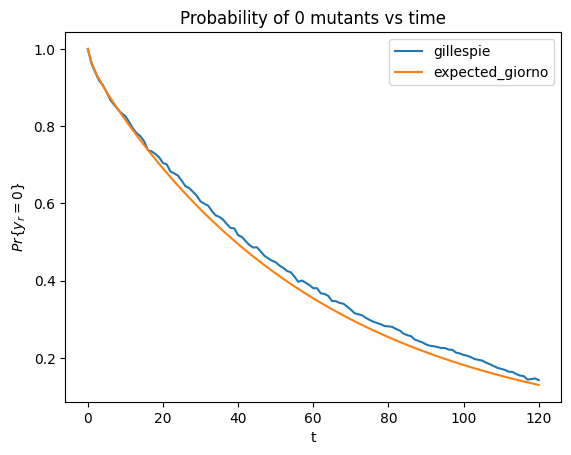

In [ ]:
gillespie_fraction = ((gillespie_df == 0).sum(axis=1) / len(gillespie_df.columns))

probability_g = p00_giorno(t_eval, p.mutant_infection_rate_at_eq(), p.a, p.mutant_generation_rate())
probability_g[0] = 1.0


ax = pd.DataFrame(data={'gillespie': gillespie_fraction, 'expected_giorno': probability_g}).plot()
ax.set_title('Probability of 0 mutants vs time')
ax.set_xlabel('t')
ax.set_ylabel('$Pr \{ y_r = 0 \}$')

#### Two scale Gillespie

$$ \emptyset \to y_s \qquad p $$
$$ y_s \to \emptyset \qquad a $$

$$ y_s \to 2 y_s \qquad k$$
$$ y_s \to y_s + y_r \qquad k \mu$$
$$ y_r \to 2 y_r \qquad k_r$$
$$ y_r \to \emptyset \qquad a $$

In [ ]:
y_s = Species('y_s')
y_r = Species('y_r')

reactions = []
reactions.append(Reaction([], [y_s], k='p'))
reactions.append(Reaction([y_s], [], k='a'))
reactions.append(Reaction([y_r], [], k='a'))

reactions.append(Reaction([y_s], [(y_s, 2)], k='k'))
reactions.append(Reaction([y_s], [y_s, y_r], k='k * mu'))

reactions.append(Reaction([y_r], [(y_r, 2)], k='k_r'))

m_two_scale = Model([y_s, y_r], reactions)

k = p.a * p.f_rep
mu = p.mutant_generation_rate() / (k * p.y0)

matching_p = {
    'k': k,
    'p': k * p.y0 * (1 - p.f_rep)/(p.f_rep),
    'a': p.a,
    'mu': mu,
    'k_r': p.mutant_infection_rate_at_eq()
}

matching_p

{'k': 0.5, 'p': 50000.0, 'a': 1.0, 'mu': 1e-06, 'k_r': 1.5}

In [ ]:
s_two_scale = GillespieSimulator(
    m_two_scale.get_k(parameters=matching_p, jit=True),
    m_two_scale.stoichiometry(),
    m_two_scale.kinetic_order(),
)

Evaluating expression: p => 50000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: k => 0.5
Evaluating expression: k * mu => 5e-07
Evaluating expression: k_r => 1.5


<Axes: >

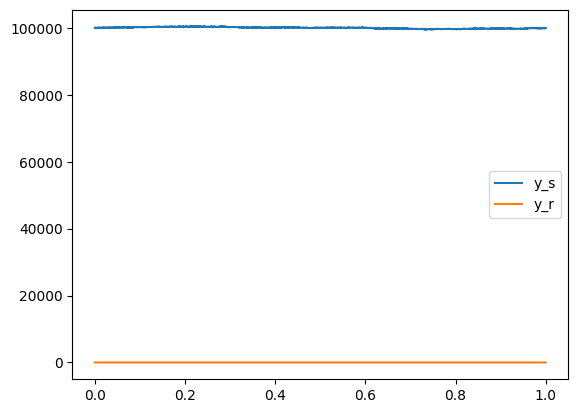

In [ ]:
def halt(t, y):
    return y[m_two_scale.legend().index('y_r')] > 100

gillespie_2_df = pd.DataFrame()
for i in range(1):
    result = s_two_scale.simulate([0.0, 1.0], m_two_scale.make_initial_condition({'y_s': p.y0}), np.random.default_rng(), t_eval=t_eval, halt=halt)
    y_r = result.y_history[m_two_scale.legend().index('y_r')]
    r = pd.Series(data=y_r, index=result.t_history)
    r.name = 'y_r'
    r = expand_truncated(r, t_eval)
    r = r[t_eval]
    assert(len(r) == len(t_eval))
    r.name = f'_r{i}'
    gillespie_df = pd.concat([gillespie_df, r], axis=1)

result.plot(m_two_scale.legend())
#plt.semilogy()
#plt.ylim(1, 1e5)

At a given equilibrium value $y^*$, wildtype cells die at a rate $a y^*$ and are produced at the same rate. The mean number of $y_s$ specimens at $t \to \infty$ is $y^*$ and the random variable describing the stochastic fluctuations around that mean is $\text{Poisson}(y^*)$.

Reactivation from the latent reservoir is approximately $r = 3.7 \cdot 10^{-4}$ reactivations per cell per day. Let's say a single mutant cell were to reemerge in favorable conditions where $R_\mu > 1$. Then the probability of its establishment from that single cell is $1 - 1/R_\mu$. If $R_\mu \approx 10$ then establishment would be $90\%$ likely. The probability that such a cell would emerge in a month is $1 - (1 - r)^{30} \approx 0.011 = 1.1\%$. So given $R_\mu = 10$, each seeding event that is ignored would neglect a $1\% /\text{month}$ chance that infection establishes under mutant-favoring conditions. Or a more realistic $0.10\%/\text{month}$ with $R_\mu = 1.1$.

## Experiments:

- Probability / unit time that a mutant emerges when wildtype is at a low level due to treatment. [Might have to introduce new term to prop it up without latency.]
- Diffusion process: ignore mutation. Given $n$ initial copies of wildtype and $R_0$ of blah (might depend on the absolute magnitudes of the birth/death rates as well), what is the mean and ~~variance~~ [index of dispersion](https://stats.stackexchange.com/questions/203766/use-cases-for-coefficient-of-variation-vs-index-of-dispersion) of the population of the wildtype after $t$ time passes. Maybe the strictest version of this scenario is to start the wildtype at its mean value.
  - variant 1: virus is at low level (survives only due to reactivation from latency)
  - variant 2: virus is at SPVL
  - variant 3: virus is at low level, but $R_0$ jumps to being greater than one at $t = 0$.
- Race to rescue: given $n$ initial copies of wildtype and active inhibition by drug, what is the distribution of times of emergence of a mutant which survives stochastic extinction (a rescue mutant).
- The GOAT experiment: seed $n$ initial copies of wildtype, let it grow [?] until some point in time. Then introduce drug and mutation. What is the probability of a mutant emerges. Depends on (1) inherent large-scale fluctuations in # of infected cells (Langevin regime essentially) (2) low level stochasticity of race to rescue. Am I sure everything doesn't wash out due to reducing observation down to one quantity (probability of emergence). Maybe instead look at the distribution of times that a rescue mutant emerges!

In [ ]:
_p = {
    'd': 0.05,
    'a': 1.0,
    'l': 1e10,
    's': .33,
    'mu': 1e-5,
    'b_s': 3e-11,
    'b_r': 2e-11,
}

_y0 = m.make_initial_condition(
    {
        'x': 'l/d',
        'y_s': 1,
        'y_r': 0
    },
    parameters=p
)

Evaluating expression: l/d => 

AttributeError: 'MutantEmergenceParameters' object has no attribute 'keys'

In [ ]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

result = solve_ivp(m.get_dydt(jit=False, parameters=p), [0.0, 100.0], y0)

ax = plt.subplot()
ax.plot(result.t, result.y.T)
ax.legend([s.name for s in m.species])
ax.set_yscale('log')
ax.set_ylim([1, 1e12])

Evaluating expression: d => 0.05
Evaluating expression: l => 10000000000.0
Evaluating expression: a => 1.0
Evaluating expression: a => 1.0
Evaluating expression: s*b_s => 9.900000000000001e-12
Evaluating expression: b_r => 2e-11
Evaluating expression: s*b_s*mu => 9.900000000000002e-17
Evaluating expression: eta => 

NameNotDefined: 'eta' is not defined for expression 'eta'

In [ ]:
import numpy as np
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

s = HybridSimulator(
    m.get_k(parameters=p, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    FixedThresholdPartitioner(100.0),
)

result = s.simulate([0.0, 100.0], y0, np.random.default_rng())

ax = plt.subplot()
ax.plot(result.t_history, result.y_history.T)
ax.legend([s.name for s in m.species])
ax.set_yscale('log')
ax.set_ylim([1, 1e12])

In [ ]:
from hybrid.gillespie import GillespieSimulator

GillespieSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

### Subquestion:

In [ ]:
a = Species('A')
b = Species('B')
r1 = Reaction([a], [b], k='k')
r2 = Reaction([b], [a], k='k')
m = Model([a, b], [r1, r2])

In [ ]:
import numpy as np
from hybrid.gillespie import GillespieSimulator

parameters = {'k': 1}

s = GillespieSimulator(
    m.get_k(parameters=parameters),
    m.stoichiometry(),
    m.kinetic_order(),
)

result = s.simulate(
    [0.0, 200.0],
    m.make_initial_condition({'A': 200, 'B': 200}),
    rng=np.random.default_rng()
)

Per Gillespie, it's a known rule of thumb in chemistry and a mathematically exact result in the Langevin regime that the fluctuations caused by the mean 0 stochastic effects are on the order of $\sqrt{N}$ for a reaction involving a species with population size $N$, whereas the deterministic part has mean proportional to the population size. Therefore the **ratio** of the stochastic effects to the deterministic ones is $N^{-1/2}$.

"The relative fluctuations in the time-evolving species populations scale as the inverse square-root of the reactant populations." A fact that "follows simply from the fact that the standard deviation of a Poisson random variable is always equal to the square root of its mean."

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result.t_history, result.y_history.T)


Possible approaches:

- Tri-partitioned into deterministic, Langevin (or tau-leaping), and Gillespie. If we could assume that the propensities are constant between stochastic events, then we could know in advance the hitting time of the stochastic subnet, in which case we would know for what rates that amounts to acceptable time step for a Langevin approximation (recall we need (i) the likely number of reactions occurring for each relevant species is much smaller than the reactant populations (a subset of propensities not changing appreciably and therefore guaranteed by assumption) and (ii) each reaction to fire multiple times.). And since these involve species counts, maybe we can use it to help construct a bridge between partitioning based on # and partitioning based on propensity

## Appendix

### Mathematical analysis

If $R_\mu$ is bounded away from $1$, then the establishment of the resistant mutant will occur while the populations of target cells and wildtype infected cells are very close to their equilibrium values ($x^*$ and $y^*$, respectively). For example, if $R_\mu = 1.1$, a population of 100 resistant mutants will go extinct with probability 7e-5. If we neglect stochastic fluctuations of $y_s$ and $x$ around their equilibrium values (the reasonableness of this choice will be discussed below), then the population of the resistant mutant obeys a linear birth-death process with immigration.

In 1958, Karlin and McGregor described the solution for the transition probability matrix $P_{ij} \equiv \text{Pr} \{ x(t) = j | x(0) = i \}$ for this process. (N.b., the formula below is only valid for $i \le j$, but there is any easy transformation to obtain the $i > j$ probabilities, the formula below is only valid for a linear term of birth rate that exceeds the linear term of death rate and that in this case $n \lambda$ is the death rate and $(n + \beta) \mu$ is the birth rate, and in the formula below $(x)_n$ denotes the [falling factorial](https://en.wikipedia.org/wiki/Falling_and_rising_factorials) of $x$):

TKTK: or is () the Pochhammer symbol? I think that makes more sense

$$ P_{ij} (t) = \left( \frac{\lambda}{\mu} \right)^{i + j} (1 - \gamma)^{-\beta} \pi_j \frac{j!}{(\beta)_j} \left(1 - \sigma/\gamma \right)^i (1 - \sigma)^{-i - \beta} e^{-(\mu - \lambda)\beta t} \times \sum_{k=0}^i {i \choose k} (-1)^k \left[\frac{1 - \frac{\sigma}{\gamma^2}}{1 - \frac{\sigma}{\gamma}}\right]^k \left[ \frac{1 - \frac{\sigma}{\gamma}}{1 - \sigma}\right]^{j-k} \frac{(i + \beta)_{j-k}}{(j - k)!}$$

where

$$ (n + \beta) \mu = \text{birth rate} $$
$$ n \lambda = \text{death rate} $$
$$ \pi_n = \left(\frac{\lambda}{\mu}\right)^n \cdot \frac{(\beta)_n}{n!} $$
$$ \sigma = \frac{\lambda}{\mu} e^{- (\mu - \lambda)t} $$
$$ \gamma = \frac{\lambda}{\mu} $$

We are concerned with the transition probabilities where $i = 0$, which are dramatically simpler:

$$ P_{0j} (t) = \pi_j \left( \frac{\lambda}{\mu} \right)^{j} \left(1 - \frac{\lambda}{\mu}\right)^{-\beta} \left( 1 - \frac{\mu \sigma}{\lambda} \right)^j (1 - \sigma)^{-j - \beta} e^{-(\mu - \lambda)\beta t}.$$

You can see that as t => 0, the term with the power of $j$ ensures that $P_{0j}$ goes to 0 if $j != 0$. For $j = 0$, we have $0^0$, which is undefined, but we can see by inspection that $P_{00} (0) = 1$ as all other terms are 0 and the total probability must sum to 1.

Recall 
$$ P_{0j} (t) = \pi_j \left( \frac{\lambda}{\mu} \right)^{j} \left(1 - \frac{\lambda}{\mu}\right)^{-\beta} \left( 1 - \frac{\mu \sigma}{\lambda} \right)^j (1 - \sigma)^{-j - \beta} e^{-(\mu - \lambda)\beta t}.$$

In which case:

$$ P_{00} (t) = \left[\left( 1 - \frac{\lambda}{\mu} \right)(1 - \sigma)\right]^{-\beta} e^{-(\mu - \lambda) \beta t} \qquad t \ne 0 $$

In the limit $t \to 0$ from above, we can Taylor expand:

$$ P_{00} (t) = \left[\left( 1 - \frac{\lambda}{\mu} \right)(1 - \sigma)\right]^{-\beta} e^{-(\mu - \lambda) \beta t} \qquad t \ne 0 $$



and

$$ \log P_{00} (t) = -\beta \left(\log \left( 1 - \frac{\lambda}{\mu} \right) + \log (1 - \sigma) \right) - (\mu - \lambda) \beta t \qquad t \ne 0 $$

which may help us calculate this quantity with less numerical instability.

# Simple variation in initial pop

In [ ]:
m = m_v_steady
p = {''}